In [551]:
import sys
sys.path.append("../")

from SALib.sample import sobol
from network_model import *
from tqdm import tqdm
import numpy as np
import pickle
import lzma
import os

from scipy.optimize import curve_fit

from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap

from astropy.stats import bayesian_blocks



import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")

# Metrics

In [3]:
def gini(W):
    n = len(W)
    total = 0
    for i in range(n):
        total += sum(np.abs(W[i]-W))
    return total / (2 * n**2 * np.mean(W))

# Problem

In [4]:
# problem definition
PROBLEM = {
    "num_vars" : 7,
    "names"    : ["project_cost",
                  "gain_right",
                  "alpha_beta",
                  "prob_left",
                  "init_w_scale",
                  "risk_scale",
                  "poisson_scale"],
    "bounds"   : [[0.01, 2.00],
                  [1.70, 2.30],
                  [0.70, 0.80],
                  [0.30, 0.45],
                  [0.01, 0.15],
                  [5.00, 20.0],
                  [8.00, 20.0]]
}

# generate Saltelli samples
NUM_SAMPLES = 1024
X = sobol.sample(PROBLEM, NUM_SAMPLES, calc_second_order=False)

In [5]:
X.shape

(9216, 7)

# Data loading

In [6]:
with open("../augmented_communities.pickle", "rb") as f:
    communities = pickle.load(f)

In [32]:
mean_last_step = []
for seed in range(10):
    data = pickle.load(lzma.open(f"../data/sobol/concat_W_arrays/{seed}_9216_1250_51.pkl.lzma"))
    for i in tqdm(range(len(data))):
        mean_last_step.append(np.mean(data[i,:,-1]))

100%|██████████| 9216/9216 [00:00<00:00, 11196.98it/s]


# Mean wealth at end of simulation

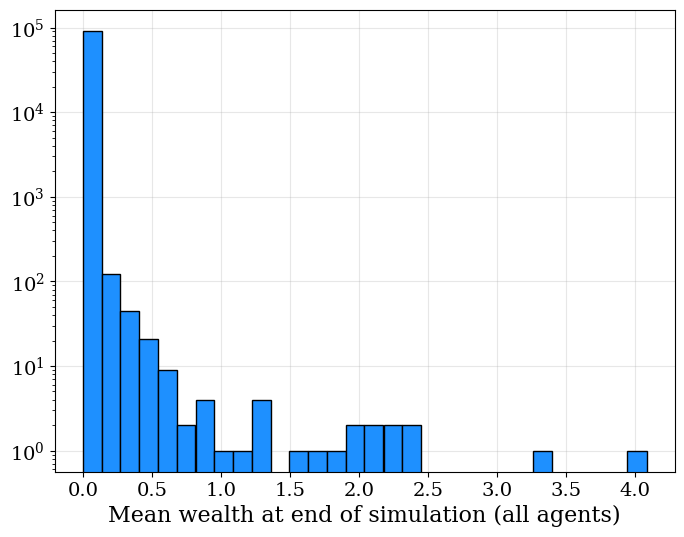

In [33]:
plt.hist(mean_last_step, color="dodgerblue", edgecolor='k', bins=30)
plt.yscale("log")
plt.xlabel("Mean wealth at end of simulation (all agents)")
plt.show()

# Plot mean trajectories for different param combinations

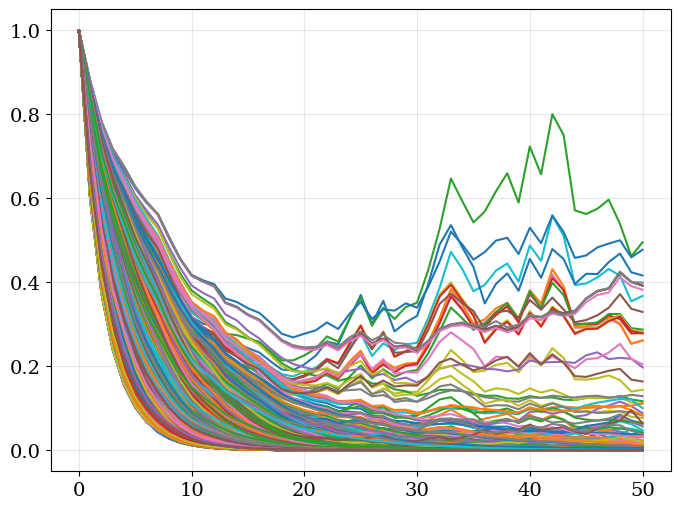

In [72]:
X = []
for i in range(len(data)):
    m = np.mean(data[i].T, axis=1)
    plt.plot(m)
    X.append(m)
    
X = np.stack(X)

# Embedding of trajectories

3it [01:39, 33.10s/it]


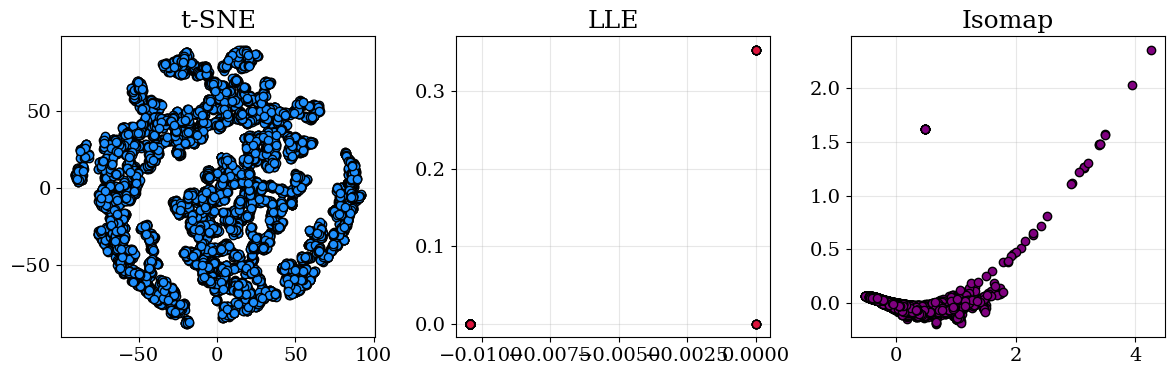

In [75]:
fig, axs = plt.subplots(1,3, figsize=(12,4))
colors = ["dodgerblue", "crimson", "purple"]
titles = ["t-SNE", "LLE", "Isomap"]
kwargs = [{"perplexity":30}, {"method":"modified"}, {}]


embeddings = {}
for i,algo in tqdm(enumerate([TSNE, LocallyLinearEmbedding, Isomap])):
    E = algo(n_components=2, **kwargs[i]).fit_transform(X)
    embeddings[titles[i]] = E
    axs[i].scatter(E[:,0], E[:,1], c=colors[i], edgecolor="k")
    axs[i].set_title(titles[i])

fig.tight_layout()
plt.show()

3it [03:10, 63.43s/it]


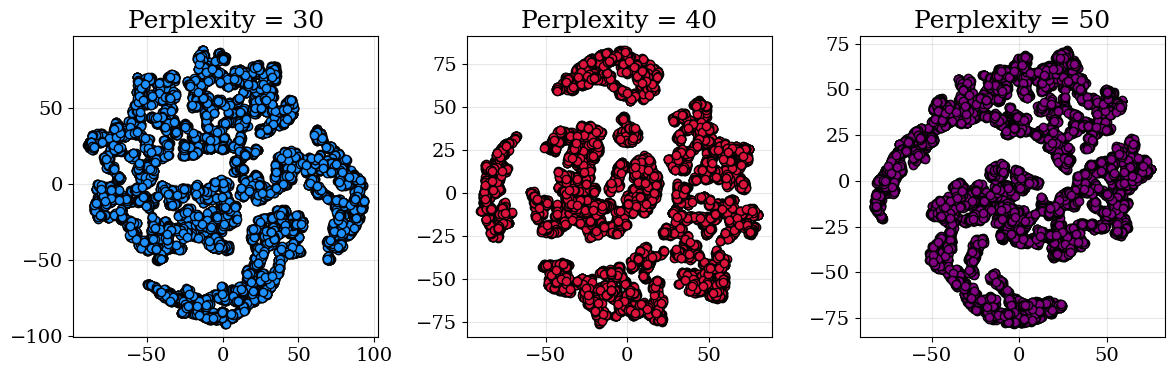

In [91]:
fig, axs = plt.subplots(1,3, figsize=(12,4))

embeddings = {}
for i,perp in tqdm(enumerate([30, 40, 50])):
    E = TSNE(n_components=2, perplexity=perp).fit_transform(X)
    embeddings[perp] = E
    axs[i].scatter(E[:,0], E[:,1], c=colors[i], edgecolor="k")
    axs[i].set_title(f"Perplexity = {perp}")

fig.tight_layout()
plt.show()

# Monotonically decreasing trajectories vs. not

In [106]:
monotonically_decreasing = []
other = []
for i in range(len(X)):
    if max(X[i][1:]-X[i][:-1]) <= 0:
        monotonically_decreasing.append(i)
    else:
        other.append(i)

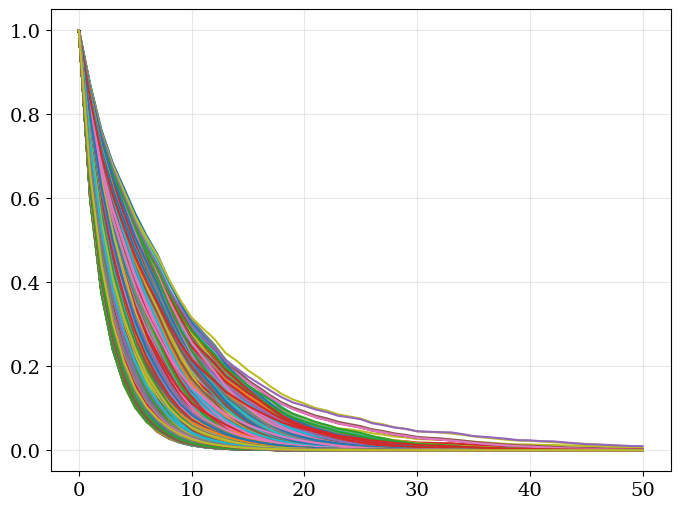

In [112]:
# plot monotonically decreasing trajectories
for i in monotonically_decreasing:
    plt.plot(X[i])
plt.show()

In [134]:
def func(x, a, b, c):
    return a*np.exp(-b*x) + c

In [237]:
exp_decay_params = []
for i in tqdm(monotonically_decreasing):
    max_t = len(X[i])
    exp = 0.05
    while exp < 0.1:
        xvals = np.arange(len(X[i]))[:max_t]
        popt, pcov = curve_fit(func, xvals, X[i][:max_t], maxfev=1000)
        exp = popt[1]
        max_t -= 1
    exp_decay_params.append(popt[1])

100%|██████████| 9029/9029 [00:08<00:00, 1119.38it/s]


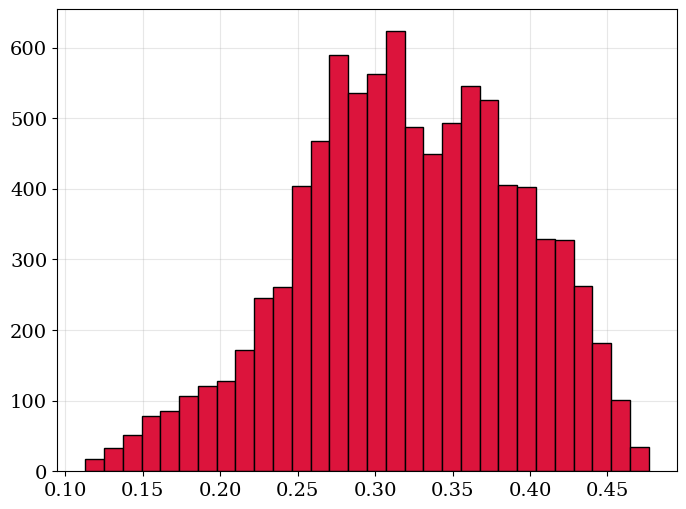

In [238]:
plt.hist(exp_decay_params, color="crimson", edgecolor="k", bins=30)
plt.show()

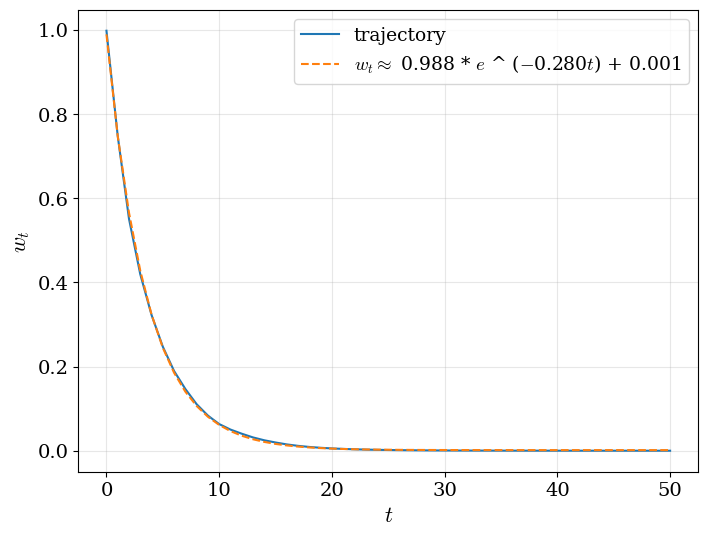

In [241]:
i = 0

xvals = np.arange(len(X[i]))
popt, pcov = curve_fit(func, xvals, X[i], maxfev=1000)


plt.plot(X[i], label="trajectory")
plt.plot(xvals, func(xvals, *popt), linestyle="dashed", 
         label=r"$w_t\approx$ " + rf"{popt[0]:.3f} * $e$ ^ ($-${popt[1]:.3f}$t$) + {popt[2]:.3f}")
plt.legend()
plt.ylabel(r"$w_t$")
plt.xlabel(r"$t$")
plt.show()

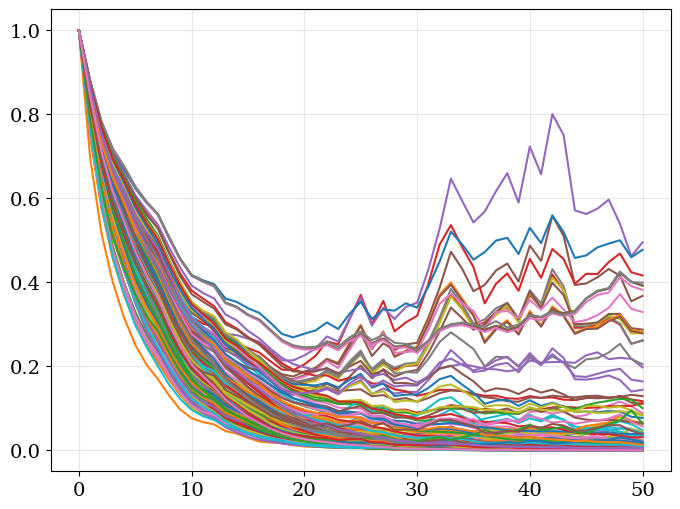

In [107]:
# plot non monotonically decreasing mean wealth trajectories
for i in other:
    plt.plot(X[i])
plt.show()

In [251]:
monotonically_decreasing[np.argmin(exp_decay_params)], monotonically_decreasing[np.argmax(exp_decay_params)]

(8490, 5572)

## Identify params where agents' wealth are all monotonically decreasing

In [291]:
decreasing = []
for i in tqdm(range(len(data))):
    d = data[i]
    mono_dec = True
    for row in d:
        if max(row[1:] - row[:-1]) > 0:
            mono_dec = False
            break
    if mono_dec:
        decreasing.append(i)

100%|██████████| 9216/9216 [00:52<00:00, 175.34it/s]


In [482]:
len(decreasing) / 9216

0.4997829861111111

## Identify params where some agents' wealth not monotonically decreasing, but never surpasses initial wealth

In [334]:
increase_less_initial = []
for i in tqdm(range(len(data))):
    if i not in decreasing:
        d = data[i]
        if np.all(np.max(data[i], axis=1) == data[i][:,0]):
            increase_less_initial.append(i)

100%|██████████| 9216/9216 [00:01<00:00, 5098.73it/s]


In [483]:
len(increase_less_initial) / 9216

0.08246527777777778

## Identify params where some agents surpassed their initial wealth, but ended up "poor"

In [359]:
surpass_end_poor = []
for i in tqdm(range(len(data))):
    if i in increase_less_initial or i in decreasing:
        continue
    else:
        if max(data[i].T[-1]) < 0.1:
            surpass_end_poor.append(i)

100%|██████████| 9216/9216 [00:01<00:00, 6864.05it/s]


In [484]:
len(surpass_end_poor) / 9216

0.4028862847222222

## Identify params where some agents avoid poverty, but still land at lower wealth than initial

In [402]:
two_equilibria_less_initial = []
for i in tqdm(range(len(data))):
    if i in decreasing + increase_less_initial + surpass_end_poor:
        continue
    else:
        if np.all(data[i].T[-1] < data[i].T[0]):
            two_equilibria_less_initial.append(i)

100%|██████████| 9216/9216 [00:01<00:00, 9082.16it/s] 


In [485]:
len(two_equilibria_less_initial) / 9216

0.004448784722222222

## Identify params where some agents avoid poverty, and end up richer than start

In [407]:
two_equilibria_richer = []
for i in tqdm(range(len(data))):
    if i in decreasing + increase_less_initial + surpass_end_poor + two_equilibria_less_initial:
        continue
    else:
        two_equilibria_richer.append(i)

100%|██████████| 9216/9216 [00:01<00:00, 7949.00it/s]


In [408]:
len(two_equilibria_richer)

96

In [ ]:
coefficients = [gini(data[i].T[-1]) for i in two_equilibria_richer]
edges = bayesian_blocks(coefficients, fitness='events', p0=0.01)

In [466]:
# bin the remaining simulations by gini coefficient
gini_coeffs = {k:[] for k in edges}
for k,i in tqdm(enumerate(two_equilibria_richer)):
    coeff = coefficients[k]
    for key in gini_coeffs:
        if coeff <= key:
            gini_coeffs[key].append(i)
            break

96it [00:00, 328965.02it/s]


7it [00:03,  2.13it/s]


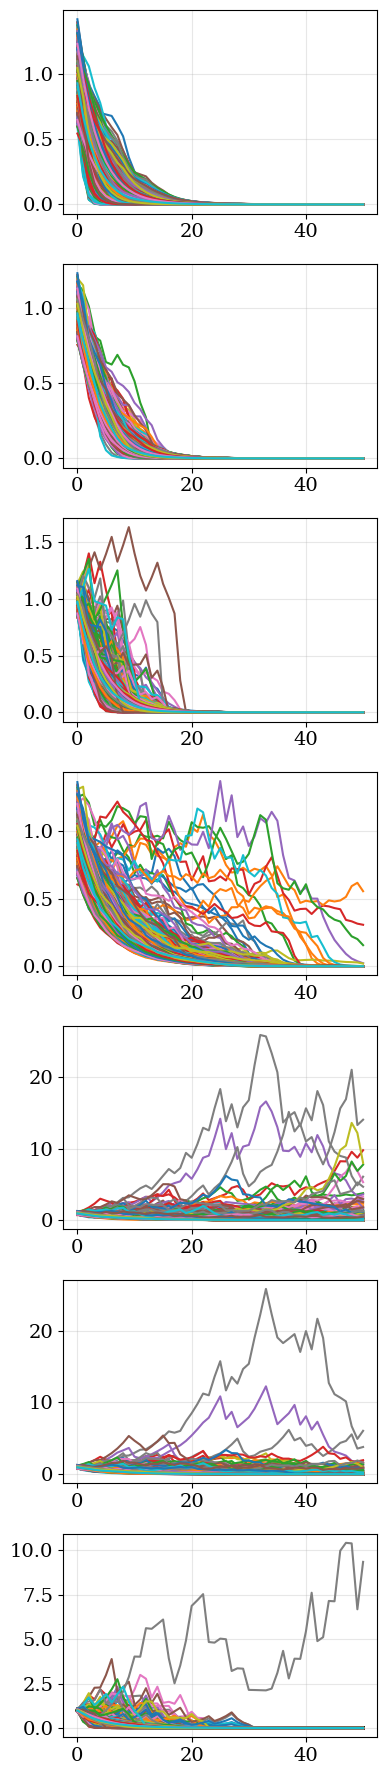

In [474]:
indices = [0, 126, 17, 9179, 2702, 7516, 2620]
fig, axs = plt.subplots(7,1, figsize=(4,18))
for i, idx in tqdm(enumerate(indices)):
    axs[i].plot(data[idx].T)

fig.tight_layout()
plt.show()

In [538]:
num_agents = []

for i in tqdm(range(len(data))):
    if i in decreasing + increase_less_initial + surpass_end_poor:
        continue
    else:
        
        # all agents have final wealth less than initial wealth
        if np.all(data[i].T[-1] < data[i].T[0]):
            
            tally = 0
            for a in range(1250):
                if max(data[i][a]) > data[i].T[-1][a] > 0.1:
                    tally += 1
                
            if tally:
                num_agents.append(tally)

100%|██████████| 9216/9216 [00:01<00:00, 6808.74it/s]


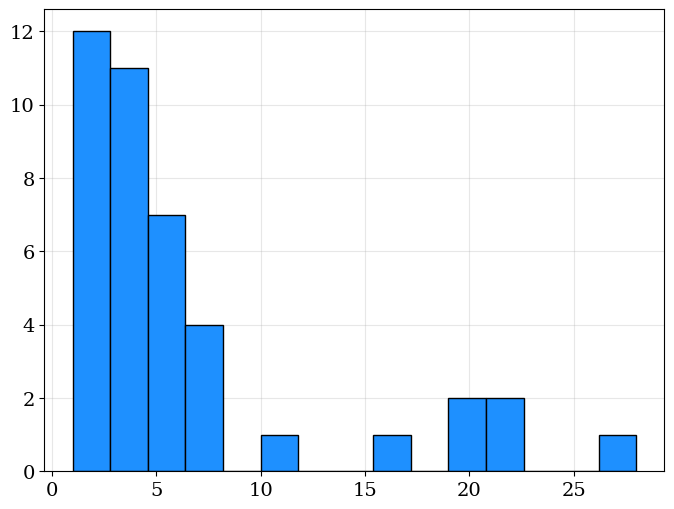

In [546]:
plt.hist(num_agents, bins=15, color="dodgerblue", edgecolor="k")
plt.show()

- mean wealth trajectories initially decay exponentially (some crash to zero, others oscillate)
- seems like we can use t-SNE to cluster different trajectories
- a number of mean wealth trajectories are monotonically decreasing, and others have increases
